In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from joblib import Parallel, delayed
import itertools


In [16]:
# --- Load EOS ---
eos_quark = pd.read_csv("../Data/EOS_MIT_Massless_quarks.csv")
grid_e_quark = eos_quark["Energy Density"].values
grid_p_quark = eos_quark["Pressure"].values

eos_dm_300 = pd.read_csv("../Data/EOS_Bosonic_DM_n4_mb300.csv")
grid_e_DM_300 = eos_dm_300["Energy Density"].values
grid_p_DM_300 = eos_dm_300["Pressure"].values

eos_dm_200 = pd.read_csv("../Data/EOS_Bosonic_DM_n4_mb200.csv")
grid_e_DM_200 = eos_dm_200["Energy Density"].values
grid_p_DM_200 = eos_dm_200["Pressure"].values

eos_dm_1000 = pd.read_csv("../Data/EOS_Bosonic_DM_n4_mb1000.csv")
grid_e_DM_1000 = eos_dm_1000["Energy Density"].values
grid_p_DM_1000 = eos_dm_1000["Pressure"].values



In [17]:
B  = 145**4
hc = 197.3269804  # MeV fm

M_p = 1.2209e22   # MeV
mev_to_kg = 1.78266192e-30
msun_kg = 1.98847e30

factor_R_to_km = (M_p / (2 * np.sqrt(B))) * hc * 1e-18
factor_M_to_Solar = (M_p**3 / (2 * np.sqrt(B))) * mev_to_kg / msun_kg


In [18]:
def run_single_star(e_q_c, p_q_c, e_dm_c, p_dm_c):

    r0 = 1e-6

    # Initial masses
    m_q_c  = (4/3) * np.pi * r0**3 * e_q_c
    m_dm_c = (4/3) * np.pi * r0**3 * e_dm_c

    x0 = [p_q_c, m_q_c, p_dm_c, m_dm_c]

    # ----------------------------------------------------
    # ODE Definition (UNCHANGED)
    # ----------------------------------------------------
    def ode_TOV(r, x):
        p1, M1, p2, M2 = x

        p1_phys = max(0.0, p1)
        p2_phys = max(0.0, p2)

        if p1_phys > 0:
            e1 = np.interp(p1_phys, grid_p_quark, grid_e_quark)
        else:
            e1 = 0.0

        if p2_phys > 0:
            e2 = np.interp(p2_phys, grid_p_DM_1000, grid_e_DM_1000)
        else:
            e2 = 0.0

        M = M1 + M2

        if r < 1e-9:
            return [0.0, 4*np.pi*r**2*e1, 0.0, 4*np.pi*r**2*e2]

        term1_q  = e1 + p1_phys
        term1_dm = e2 + p2_phys
        term2 = 1 + 4*np.pi*r**3*(p1_phys + p2_phys)/M
        term3 = 1 - 2*M/r

        if term3 <= 1e-9:
            return [0.0, 0.0, 0.0, 0.0]

        factor = -(M / r**2) / term3

        if p1 <= 0:
            dp1dr = 0.0
            dM1dr = 0.0
        else:
            dp1dr = factor * term1_q * term2
            dM1dr = 4*np.pi*r**2 * e1

        if p2 <= 0:
            dp2dr = 0.0
            dM2dr = 0.0
        else:
            dp2dr = factor * term1_dm * term2
            dM2dr = 4*np.pi*r**2 * e2

        return [dp1dr, dM1dr, dp2dr, dM2dr]

    # ----------------------------------------------------
    # Events (UNCHANGED)
    # ----------------------------------------------------
    def event_DM_surface(r, x):
        return x[2]
    event_DM_surface.terminal = False
    event_DM_surface.direction = -1

    def event_Quark_surface(r, x):
        return x[0]
    event_Quark_surface.terminal = True
    event_Quark_surface.direction = -1

    # ----------------------------------------------------
    # Solve
    # ----------------------------------------------------
    sol = solve_ivp(
        ode_TOV,
        (r0, 1e12),
        x0,
        events=[event_DM_surface, event_Quark_surface],
        rtol=1e-8,
        atol=1e-10,
        first_step=1e-7
    )

    r = sol.t
    p1, m1, p2, m2 = sol.y

    # --- LAST POSITIVE PRESSURE ---
    q_mask  = p1 > 0
    dm_mask = p2 > 0

    R_q  = r[q_mask][-1]  if np.any(q_mask)  else 0.0
    M_q  = m1[q_mask][-1] if np.any(q_mask)  else 0.0
    R_dm = r[dm_mask][-1] if np.any(dm_mask) else 0.0
    M_dm = m2[dm_mask][-1]if np.any(dm_mask) else 0.0

    return {
        "Central E Quark": e_q_c,
        "Central E DM": e_dm_c,
        "R_quark": R_q,
        "M_quark": M_q,
        "R_dm": R_dm,
        "M_dm": M_dm,
        "R_total": max(R_q, R_dm),
        "M_total": M_q + M_dm
    }


In [ ]:
e_surface_quark = grid_e_quark[0]

list_e_quark = np.logspace(
    np.log10(e_surface_quark * (1 + 1e-20)),
    np.log10(grid_e_quark[-1]),
    100
)
list_p_quark = np.interp(list_e_quark, grid_e_quark, grid_p_quark)

list_e_dm = np.logspace(-3, 2, 50)
list_p_dm = np.interp(list_e_dm, grid_e_DM_1000, grid_p_DM_1000)




In [20]:
param_list = [
    (eq, pq, edm, pdm)
    for (eq, pq), (edm, pdm)
    in itertools.product(
        zip(list_e_quark, list_p_quark),
        zip(list_e_dm, list_p_dm)
    )
]

results = Parallel(n_jobs=-1, verbose=10)(
    delayed(run_single_star)(*p) for p in param_list
)

results_df = pd.DataFrame(results)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.07659506797790527s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.19562505650683892s.) Setting batch_size=4.
[Parallel(n_jobs=-1)]: Done  74 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done  98 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 148 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 200 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 260 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 320 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Batch computation too fast 

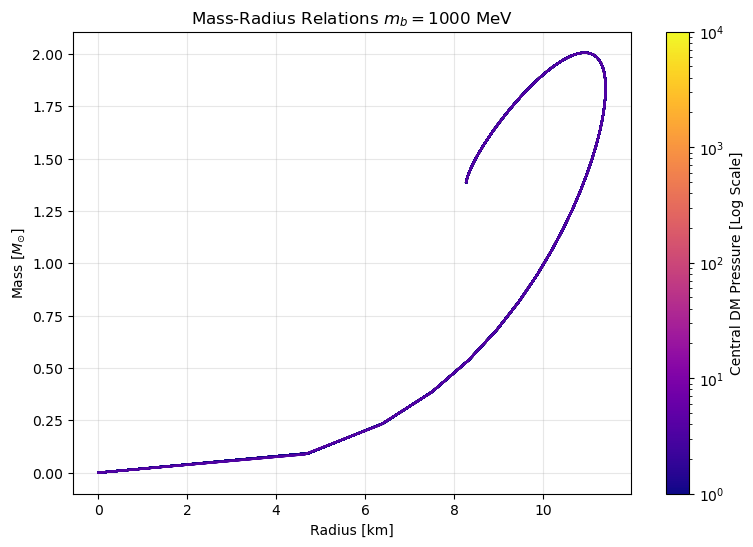

In [23]:

import matplotlib.colors as mcolors # Import this for the Log scale
import numpy as np

# 1. Calculate Pressure
# Ensure your constants (B, hc) are defined or replace with values
results_df["P_DM"] = np.interp(results_df["Central E DM"].values, grid_e_DM_1000, grid_p_DM_1000) * (4 * B / (hc**3))

unique_dm_conditions = results_df["Central E DM"].unique()

plt.figure(figsize=(9, 6))

# 2. Define the Logarithmic Normalizer
# This forces the colorbar to work in Log10 scale.
# vmin=1.0 covers "below 10^1"
# vmax=10000.0 covers "beyond 10^3"
norm = mcolors.LogNorm(vmin=1.0, vmax=10000.0)

# 3. Create the "Dummy" Scatter Plot for the Colorbar
# We pass the 'norm' here so the colorbar knows it is logarithmic.
sc = plt.scatter(
    [], [], 
    c=[], 
    cmap='plasma', 
    norm=norm # Apply the log normalization here
)

# 4. Plotting Loop
for e_dm in unique_dm_conditions:
    subset = results_df[results_df["Central E DM"] == e_dm]
    
    # Optional: If your lines look like "scribbles", uncomment the next line to sort by density
    # subset = subset.sort_values(by="Central E Quark")
    
    pressure_val = subset["P_DM"].iloc[0]
    
    plt.plot(
        subset["R_total"] * factor_R_to_km, 
        subset["M_total"] * factor_M_to_Solar,
        color=sc.to_rgba(pressure_val), # Maps the pressure to the Log Color
        linewidth=1.5
    )

# 5. Add the Colorbar
cbar = plt.colorbar(sc)
cbar.set_label("Central DM Pressure [Log Scale]")

plt.xlabel("Radius [km]")
plt.ylabel("Mass [$M_{\odot}$]")
plt.title("Mass-Radius Relations $m_b = 1000$ MeV")
plt.grid(True, alpha=0.3)
plt.show()

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1953690478141931s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.10520100593566895s.) Setting batch_size=4.
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.10667991638183594s.) Setting batch_size=8.
[Parallel(n_jobs=-1)]: Done 100 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done 160 tasks      | elapsed:    4.1s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:    4.7s
[Parallel(n_jobs=

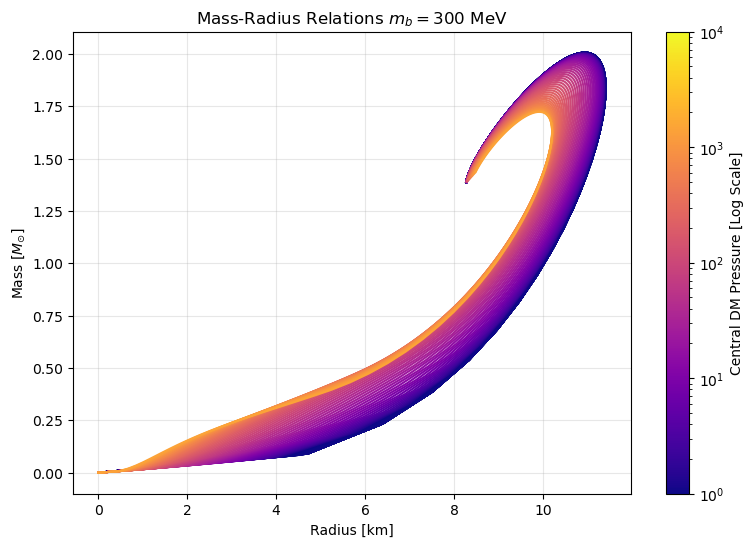

In [ ]:
def run_single_star(e_q_c, p_q_c, e_dm_c, p_dm_c):

    r0 = 1e-6

    # Initial masses
    m_q_c  = (4/3) * np.pi * r0**3 * e_q_c
    m_dm_c = (4/3) * np.pi * r0**3 * e_dm_c

    x0 = [p_q_c, m_q_c, p_dm_c, m_dm_c]

    # ----------------------------------------------------
    # ODE Definition (UNCHANGED)
    # ----------------------------------------------------
    def ode_TOV(r, x):
        p1, M1, p2, M2 = x

        p1_phys = max(0.0, p1)
        p2_phys = max(0.0, p2)

        if p1_phys > 0:
            e1 = np.interp(p1_phys, grid_p_quark, grid_e_quark)
        else:
            e1 = 0.0

        if p2_phys > 0:
            e2 = np.interp(p2_phys, grid_p_DM_300, grid_e_DM_300)
        else:
            e2 = 0.0

        M = M1 + M2

        if r < 1e-9:
            return [0.0, 4*np.pi*r**2*e1, 0.0, 4*np.pi*r**2*e2]

        term1_q  = e1 + p1_phys
        term1_dm = e2 + p2_phys
        term2 = 1 + 4*np.pi*r**3*(p1_phys + p2_phys)/M
        term3 = 1 - 2*M/r

        if term3 <= 1e-9:
            return [0.0, 0.0, 0.0, 0.0]

        factor = -(M / r**2) / term3

        if p1 <= 0:
            dp1dr = 0.0
            dM1dr = 0.0
        else:
            dp1dr = factor * term1_q * term2
            dM1dr = 4*np.pi*r**2 * e1

        if p2 <= 0:
            dp2dr = 0.0
            dM2dr = 0.0
        else:
            dp2dr = factor * term1_dm * term2
            dM2dr = 4*np.pi*r**2 * e2

        return [dp1dr, dM1dr, dp2dr, dM2dr]

    # ----------------------------------------------------
    # Events (UNCHANGED)
    # ----------------------------------------------------
    def event_DM_surface(r, x):
        return x[2]
    event_DM_surface.terminal = False
    event_DM_surface.direction = -1

    def event_Quark_surface(r, x):
        return x[0]
    event_Quark_surface.terminal = True
    event_Quark_surface.direction = -1

    # ----------------------------------------------------
    # Solve
    # ----------------------------------------------------
    sol = solve_ivp(
        ode_TOV,
        (r0, 1e12),
        x0,
        events=[event_DM_surface, event_Quark_surface],
        rtol=1e-8,
        atol=1e-10,
        first_step=1e-7
    )

    r = sol.t
    p1, m1, p2, m2 = sol.y

    # --- LAST POSITIVE PRESSURE ---
    q_mask  = p1 > 0
    dm_mask = p2 > 0

    R_q  = r[q_mask][-1]  if np.any(q_mask)  else 0.0
    M_q  = m1[q_mask][-1] if np.any(q_mask)  else 0.0
    R_dm = r[dm_mask][-1] if np.any(dm_mask) else 0.0
    M_dm = m2[dm_mask][-1]if np.any(dm_mask) else 0.0

    return {
        "Central E Quark": e_q_c,
        "Central E DM": e_dm_c,
        "R_quark": R_q,
        "M_quark": M_q,
        "R_dm": R_dm,
        "M_dm": M_dm,
        "R_total": max(R_q, R_dm),
        "M_total": M_q + M_dm
    }


e_surface_quark = grid_e_quark[0]

list_e_quark = np.logspace(
    np.log10(e_surface_quark * (1 + 1e-20)),
    np.log10(grid_e_quark[-1]),
    100
)
list_p_quark = np.interp(list_e_quark, grid_e_quark, grid_p_quark)

list_e_dm = np.logspace(-3, 2, 50)
list_p_dm = np.interp(list_e_dm, grid_e_DM_300, grid_p_DM_300)



param_list = [
    (eq, pq, edm, pdm)
    for (eq, pq), (edm, pdm)
    in itertools.product(
        zip(list_e_quark, list_p_quark),
        zip(list_e_dm, list_p_dm)
    )
]

results = Parallel(n_jobs=-1, verbose=10)(
    delayed(run_single_star)(*p) for p in param_list
)

results_df = pd.DataFrame(results)


# 1. Calculate Pressure
# Ensure your constants (B, hc) are defined or replace with values
results_df["P_DM"] = np.interp(results_df["Central E DM"].values, grid_e_DM_300, grid_p_DM_300) * (4 * B / (hc**3))

unique_dm_conditions = results_df["Central E DM"].unique()

plt.figure(figsize=(9, 6))

# 2. Define the Logarithmic Normalizer
# This forces the colorbar to work in Log10 scale.
# vmin=1.0 covers "below 10^1"
# vmax=10000.0 covers "beyond 10^3"
norm = mcolors.LogNorm(vmin=1.0, vmax=10000.0)

# 3. Create the "Dummy" Scatter Plot for the Colorbar
# We pass the 'norm' here so the colorbar knows it is logarithmic.
sc = plt.scatter(
    [], [], 
    c=[], 
    cmap='plasma', 
    norm=norm # Apply the log normalization here
)

# 4. Plotting Loop
for e_dm in unique_dm_conditions:
    subset = results_df[results_df["Central E DM"] == e_dm]
    
    # Optional: If your lines look like "scribbles", uncomment the next line to sort by density
    # subset = subset.sort_values(by="Central E Quark")
    
    pressure_val = subset["P_DM"].iloc[0]
    
    plt.plot(
        subset["R_total"] * factor_R_to_km, 
        subset["M_total"] * factor_M_to_Solar,
        color=sc.to_rgba(pressure_val), # Maps the pressure to the Log Color
        linewidth=1.5
    )

# 5. Add the Colorbar
cbar = plt.colorbar(sc)
cbar.set_label("Central DM Pressure [Log Scale]")

plt.xlabel("Radius [km]")
plt.ylabel("Mass [$M_{\odot}$]")
plt.title("Mass-Radius Relations $m_b = 300$ MeV")
plt.grid(True, alpha=0.3)
plt.show()

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.05790376663208008s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.19033769448901372s.) Setting batch_size=4.
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done  74 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.12880206108093262s.) Setting batch_size=8.
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.18217706680297852s.) Setting batch_size=16.
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 304 tasks      

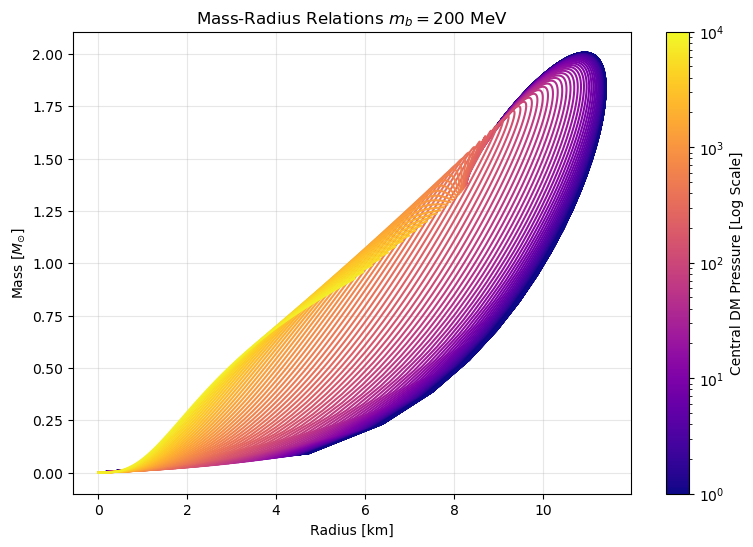

In [25]:
def run_single_star(e_q_c, p_q_c, e_dm_c, p_dm_c):

    r0 = 1e-6

    # Initial masses
    m_q_c  = (4/3) * np.pi * r0**3 * e_q_c
    m_dm_c = (4/3) * np.pi * r0**3 * e_dm_c

    x0 = [p_q_c, m_q_c, p_dm_c, m_dm_c]

    # ----------------------------------------------------
    # ODE Definition (UNCHANGED)
    # ----------------------------------------------------
    def ode_TOV(r, x):
        p1, M1, p2, M2 = x

        p1_phys = max(0.0, p1)
        p2_phys = max(0.0, p2)

        if p1_phys > 0:
            e1 = np.interp(p1_phys, grid_p_quark, grid_e_quark)
        else:
            e1 = 0.0

        if p2_phys > 0:
            e2 = np.interp(p2_phys, grid_p_DM_200, grid_e_DM_200)
        else:
            e2 = 0.0

        M = M1 + M2

        if r < 1e-9:
            return [0.0, 4*np.pi*r**2*e1, 0.0, 4*np.pi*r**2*e2]

        term1_q  = e1 + p1_phys
        term1_dm = e2 + p2_phys
        term2 = 1 + 4*np.pi*r**3*(p1_phys + p2_phys)/M
        term3 = 1 - 2*M/r

        if term3 <= 1e-9:
            return [0.0, 0.0, 0.0, 0.0]

        factor = -(M / r**2) / term3

        if p1 <= 0:
            dp1dr = 0.0
            dM1dr = 0.0
        else:
            dp1dr = factor * term1_q * term2
            dM1dr = 4*np.pi*r**2 * e1

        if p2 <= 0:
            dp2dr = 0.0
            dM2dr = 0.0
        else:
            dp2dr = factor * term1_dm * term2
            dM2dr = 4*np.pi*r**2 * e2

        return [dp1dr, dM1dr, dp2dr, dM2dr]

    # ----------------------------------------------------
    # Events (UNCHANGED)
    # ----------------------------------------------------
    def event_DM_surface(r, x):
        return x[2]
    event_DM_surface.terminal = False
    event_DM_surface.direction = -1

    def event_Quark_surface(r, x):
        return x[0]
    event_Quark_surface.terminal = True
    event_Quark_surface.direction = -1

    # ----------------------------------------------------
    # Solve
    # ----------------------------------------------------
    sol = solve_ivp(
        ode_TOV,
        (r0, 1e12),
        x0,
        events=[event_DM_surface, event_Quark_surface],
        rtol=1e-8,
        atol=1e-10,
        first_step=1e-7
    )

    r = sol.t
    p1, m1, p2, m2 = sol.y

    # --- LAST POSITIVE PRESSURE ---
    q_mask  = p1 > 0
    dm_mask = p2 > 0

    R_q  = r[q_mask][-1]  if np.any(q_mask)  else 0.0
    M_q  = m1[q_mask][-1] if np.any(q_mask)  else 0.0
    R_dm = r[dm_mask][-1] if np.any(dm_mask) else 0.0
    M_dm = m2[dm_mask][-1]if np.any(dm_mask) else 0.0

    return {
        "Central E Quark": e_q_c,
        "Central E DM": e_dm_c,
        "R_quark": R_q,
        "M_quark": M_q,
        "R_dm": R_dm,
        "M_dm": M_dm,
        "R_total": max(R_q, R_dm),
        "M_total": M_q + M_dm
    }


e_surface_quark = grid_e_quark[0]

list_e_quark = np.logspace(
    np.log10(e_surface_quark * (1 + 1e-20)),
    np.log10(grid_e_quark[-1]),
    100
)
list_p_quark = np.interp(list_e_quark, grid_e_quark, grid_p_quark)

list_e_dm = np.logspace(-3, 2, 50)
list_p_dm = np.interp(list_e_dm, grid_e_DM_200, grid_p_DM_200)



param_list = [
    (eq, pq, edm, pdm)
    for (eq, pq), (edm, pdm)
    in itertools.product(
        zip(list_e_quark, list_p_quark),
        zip(list_e_dm, list_p_dm)
    )
]

results = Parallel(n_jobs=-1, verbose=10)(
    delayed(run_single_star)(*p) for p in param_list
)

results_df = pd.DataFrame(results)


# 1. Calculate Pressure
# Ensure your constants (B, hc) are defined or replace with values
results_df["P_DM"] = np.interp(results_df["Central E DM"].values, grid_e_DM_200, grid_p_DM_200) * (4 * B / (hc**3))

unique_dm_conditions = results_df["Central E DM"].unique()

plt.figure(figsize=(9, 6))

# 2. Define the Logarithmic Normalizer
# This forces the colorbar to work in Log10 scale.
# vmin=1.0 covers "below 10^1"
# vmax=10000.0 covers "beyond 10^3"
norm = mcolors.LogNorm(vmin=1.0, vmax=10000.0)

# 3. Create the "Dummy" Scatter Plot for the Colorbar
# We pass the 'norm' here so the colorbar knows it is logarithmic.
sc = plt.scatter(
    [], [], 
    c=[], 
    cmap='plasma', 
    norm=norm # Apply the log normalization here
)

# 4. Plotting Loop
for e_dm in unique_dm_conditions:
    subset = results_df[results_df["Central E DM"] == e_dm]
    
    # Optional: If your lines look like "scribbles", uncomment the next line to sort by density
    # subset = subset.sort_values(by="Central E Quark")
    
    pressure_val = subset["P_DM"].iloc[0]
    
    plt.plot(
        subset["R_total"] * factor_R_to_km, 
        subset["M_total"] * factor_M_to_Solar,
        color=sc.to_rgba(pressure_val), # Maps the pressure to the Log Color
        linewidth=1.5
    )

# 5. Add the Colorbar
cbar = plt.colorbar(sc)
cbar.set_label("Central DM Pressure [Log Scale]")

plt.xlabel("Radius [km]")
plt.ylabel("Mass [$M_{\odot}$]")
plt.title("Mass-Radius Relations $m_b = 200$ MeV")
plt.grid(True, alpha=0.3)
plt.show()